## Simple Audio Inference without using TensorFlow for preprocessing data

We will use scipy/numpy instead.

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import pyaudio

from scipy.io import wavfile
from scipy import signal
import IPython

In [3]:
model = tf.keras.models.load_model('simple_audio_model.sav')
print('loaded saved model.')
print(model.summary())

loaded saved model.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 

### Create spectrogram from WAV file.


**Set wav file**

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
wavfile_name = data_dir/'stop/c1d39ce8_nohash_9.wav'
#wavfile_name = data_dir/'no/01bb6a2a_nohash_0.wav'
#wavfile_name = data_dir/'left/c6ee87a7_nohash_3.wav'

IPython.display.Audio(wavfile_name)

## Using TensorFlow

In [17]:
def get_spectrogram(wavfile_name, use_numpy):
    
    rate, waveform = wavfile.read(wavfile_name)
    waveform = waveform / 32768.0
    spectrogram = None
        
    if use_numpy:
        # Padding for files with less than 16000 samples
        #zero_padding = np.zeros([16000] - np.shape(waveform), dtype=np.float32)
        
        f, t, Zxx = signal.stft(waveform, fs=16000, nperseg=255, nfft=256)
        spectrogram = np.abs(Zxx)
    else:
        # Padding for files with less than 16000 samples
        zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
        print("zp:", zero_padding)

        # Concatenate audio with padding so that all audio clips will be of the 
        # same length
        waveform = tf.cast(waveform, tf.float32)
        equal_length = tf.concat([waveform, zero_padding], 0)
        spectrogram = tf.signal.stft(
          equal_length, frame_length=255, frame_step=128)

        spectrogram = tf.abs(spectrogram)

    print("waveform:", waveform.shape, type(waveform))
    print(waveform[:5])

    print("spectrogram:", spectrogram.shape, type(spectrogram))
    print(spectrogram[0, 0])
        
    return waveform, spectrogram

def plot_spectrogram(spectrogram, ax, use_numpy):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    
    if use_numpy:
        log_spec = np.log(spectrogram)
    else:
        log_spec = np.log(spectrogram.numpy().T)

    height = log_spec.shape[0]
    X = np.arange(16000, step=height + 1)
    Y = range(height)
    print("plot_spectrogram:", X.shape, Y, log_spec.shape)
    ax.pcolormesh(X, Y, log_spec)

    
def get_inference(wavfile_name, use_numpy):
    
    waveform, spectrogram = get_spectrogram(wavfile_name, use_numpy)
    
    # plot input
    fig, axes = plt.subplots(2, figsize=(12, 8))
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform)
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, 16000])
    axes[0].set_ylim([-1, 1])
    
    # plot spectrogram
    plot_spectrogram(spectrogram, axes[1], use_numpy)
    axes[1].set_title('Spectrogram')
    plt.show()

    commands = ['go', 'down', 'up', 'stop', 'yes', 'left', 'right', 'no']
    print(spectrogram.shape)

    spectrogram1= tf.reshape(spectrogram, (-1, spectrogram.shape[0], spectrogram.shape[1], 1))
    print(spectrogram1.shape)

    print("debug:", spectrogram1.numpy().T[0][0][0:2])

    prediction = model(spectrogram1)
    print(prediction)
    sm = tf.nn.softmax(prediction[0])
    am = tf.math.argmax(sm)
    print(sm)
    print(commands[am])

zp: tf.Tensor([], shape=(0,), dtype=float32)
waveform: (16000,) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0.0010376  0.0010376  0.00128174 0.00183105 0.0017395 ], shape=(5,), dtype=float32)
spectrogram: (124, 129) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.014126504, shape=(), dtype=float32)
plot_spectrogram: (124,) range(0, 129) (129, 124)


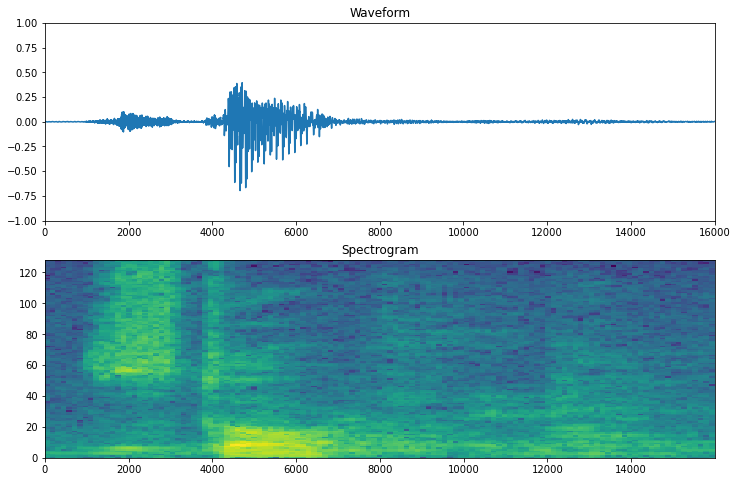

(124, 129)
(1, 124, 129, 1)
debug: [[0.0141265 ]
 [0.00482849]]
tf.Tensor(
[[  0.8579409    1.3281908    0.62363434  13.248563   -11.922053
   -2.5320258   -6.088669    -2.1415377 ]], shape=(1, 8), dtype=float32)
tf.Tensor(
[4.15733393e-06 6.65337438e-06 3.28894771e-06 9.99985576e-01
 1.17093835e-11 1.40142987e-07 3.99890565e-09 2.07089471e-07], shape=(8,), dtype=float32)
stop


In [18]:
get_inference(wavfile_name, False)

waveform: (16000,) <class 'numpy.ndarray'>
[0.0010376  0.0010376  0.00128174 0.00183105 0.0017395 ]
spectrogram: (129, 126) <class 'numpy.ndarray'>
0.0002058614427357707
plot_spectrogram: (124,) range(0, 129) (129, 126)


TypeError: Dimensions of C (129, 126) are incompatible with X (124) and/or Y (129); see help(pcolormesh)

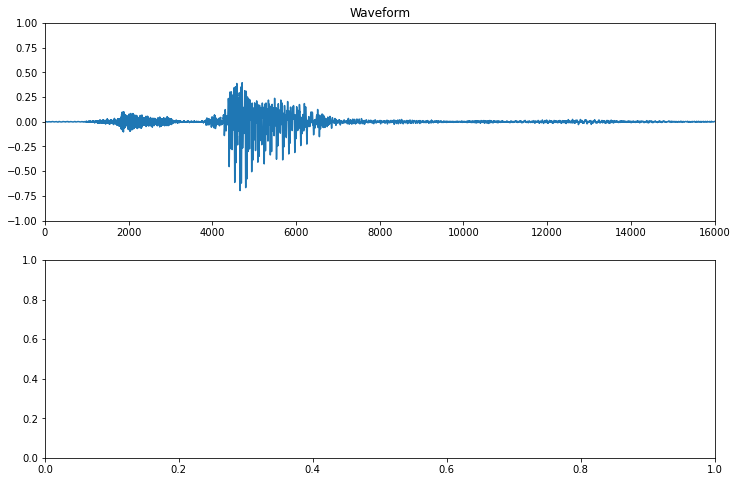

In [19]:
get_inference(wavfile_name, True)

In [32]:
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power),
                         size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise
#Compute and plot the STFT’s magnitude.

f, t, Zxx = signal.stft(x, fs, nperseg=1000)
out = np.abs(Zxx)
print(out.shape)
print(out[0, 0])

out_tf = tf.signal.stft(x, frame_length=1000, frame_step = 500)
out_tf = tf.abs(out_tf)
print(out_tf.shape)
print(out_tf[0, 0])


(501, 201)
0.26866383675292776
(199, 513)
tf.Tensor(173.9106044270169, shape=(), dtype=float64)
